In [2]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt 
import mpmath
import timeit

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("./ZERN/"))

from zern.zern_core import Zernike
import numpy as np

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("./zernike/"))
from zernike import RZern

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("./zernpy/src/"))
from zernpy import ZernPol

from zernipax.basis import ZernikePolynomial
from zernipax.zernike import *
from zernipax.plotting import plot_comparison
from zernipax.backend import jax
from tqdm import tqdm

fontsize = 16
plt.rcParams.update({'font.size': fontsize})
plt.rc('legend', fontsize=fontsize-4)    # legend fontsize

using JAX backend, jax version=0.4.28, jaxlib version=0.4.28, dtype=float64
Using device: CPU, with 6.71 GB available memory


In [4]:
mpmath.mp.dps = 54
print("Decimal places of precision (dps):", mpmath.mp.dps)
print("Bit precision (prec):", mpmath.mp.prec)

Decimal places of precision (dps): 54
Bit precision (prec): 183


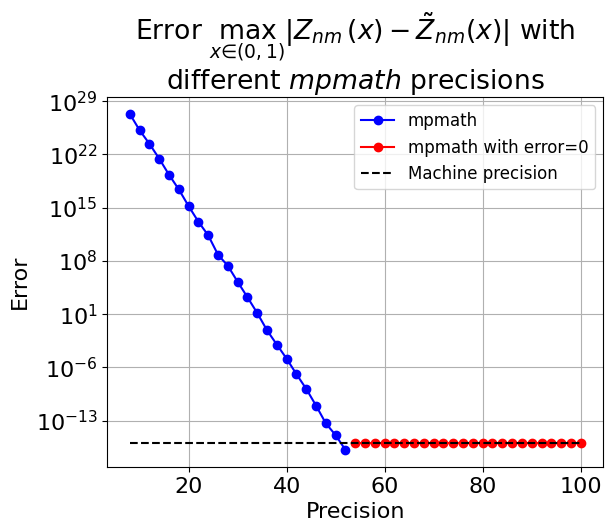

In [43]:
results = np.loadtxt("results/001_results_precision.txt")
precisions = results[:,0]
errors = results[:,1]
idx = np.argwhere(errors<1e-18)
ridx = np.argwhere(errors>1e-18)
# print(idx, ridx)
errors[idx] = 2**-53                                                 

title = "Error $\\max_{x \\in (0,1)} |Z_{nm}(x)-\\tilde{Z}_{nm}(x)|$ with\ndifferent $mpmath$ precisions"

plt.semilogy(precisions[ridx], errors[ridx], "o-", color="blue", label="mpmath")
plt.semilogy(precisions[idx], errors[idx], "o-", color="red", label="mpmath with error=0")
plt.semilogy([8, 100], [2**-53, 2**-53], "--", color="black", label="Machine precision")
# plt.text(10, 2**-50, "64-bit Machine Precision", color="black")
plt.grid()
plt.legend()
plt.xlabel("Precision")
plt.ylabel("Error")
plt.title(title)
plt.savefig("precision_comparision.png", dpi=1000, bbox_inches='tight')

In [36]:
bitwise = []

for prec in precisions:
    mpmath.mp.dps = prec
    bitwise.append(mpmath.mp.prec)

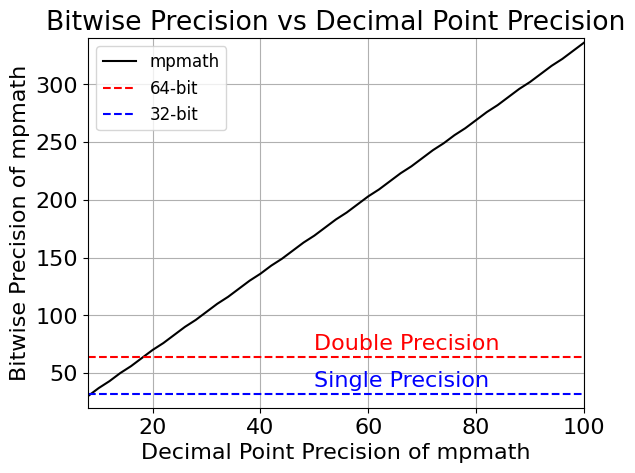

In [46]:
plt.plot(precisions, bitwise, color="black", label="mpmath")
plt.plot([8, 100], [64, 64], "--", color="red", label="64-bit")
plt.plot([8, 100], [32, 32], "--", color="blue", label="32-bit")
plt.text(50, 70, "Double Precision", color="red")
plt.text(50, 38, "Single Precision", color="blue")
plt.legend()
plt.xlim(8, 100)
plt.ylim(20, 340)
plt.grid()
plt.xlabel("Decimal Point Precision of mpmath")
plt.ylabel("Bitwise Precision of mpmath")
plt.title("Bitwise Precision vs Decimal Point Precision")
plt.savefig("bitwise_precision.png", dpi=1000, bbox_inches='tight')

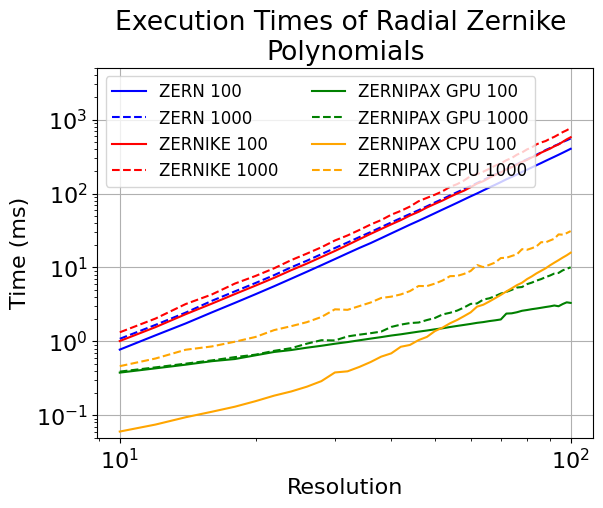

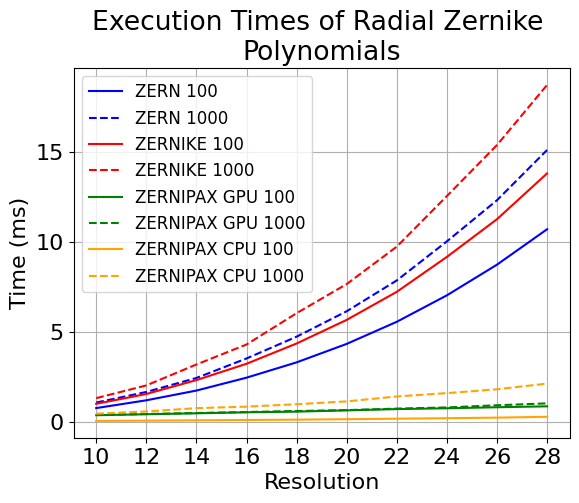

In [45]:
results100 = np.loadtxt("results_cpu_gpu_times_r100.txt")
results1000 = np.loadtxt("results_cpu_gpu_times_r1000.txt")
range_res = results100[:,0]
times100 = results100[:,1:]
times1000 = results1000[:,1:]

c1 = "blue"
c2 = "red"
c3 = "green"
c4 = "orange"

plt.figure()
plt.loglog(range_res, times100[:, 0], color=c1, label="ZERN 100")
plt.loglog(range_res, times1000[:, 0], "--", color=c1, label="ZERN 1000")
plt.loglog(range_res, times100[:, 1], color=c2, label="ZERNIKE 100")
plt.loglog(range_res, times1000[:, 1], "--", color=c2, label="ZERNIKE 1000")
plt.loglog(range_res, times100[:, 2], color=c3, label="ZERNIPAX GPU 100")
plt.loglog(range_res, times1000[:, 2], "--", color=c3, label="ZERNIPAX GPU 1000")
plt.loglog(range_res, times100[:, 3], color=c4, label="ZERNIPAX CPU 100")
plt.loglog(range_res, times1000[:, 3], "--", color=c4, label="ZERNIPAX CPU 1000")
plt.xlabel("Resolution")
plt.ylabel("Time (ms)")
plt.title("Execution Times of Radial Zernike \nPolynomials")
plt.grid()
plt.ylim(5e-2, 5e3)
plt.legend(ncol=2)
plt.savefig("001_all_t_compare_log.png", dpi=1000, bbox_inches='tight')

plt.figure()
plt.plot(range_res[:10], times100[:, 0][:10], color=c1, label="ZERN 100")
plt.plot(range_res[:10], times1000[:, 0][:10], "--", color=c1, label="ZERN 1000")
plt.plot(range_res[:10], times100[:, 1][:10], color=c2, label="ZERNIKE 100")
plt.plot(range_res[:10], times1000[:, 1][:10], "--", color=c2, label="ZERNIKE 1000")
plt.plot(range_res[:10], times100[:, 2][:10], color=c3, label="ZERNIPAX GPU 100")
plt.plot(range_res[:10], times1000[:, 2][:10], "--", color=c3, label="ZERNIPAX GPU 1000")
plt.plot(range_res[:10], times100[:, 3][:10], color=c4, label="ZERNIPAX CPU 100")
plt.plot(range_res[:10], times1000[:, 3][:10], "--", color=c4, label="ZERNIPAX CPU 1000")
plt.xlabel("Resolution")
plt.ylabel("Time (ms)")
plt.xticks(range_res[:10])
plt.title("Execution Times of Radial Zernike \nPolynomials")
plt.grid()
plt.legend(ncol=1)
plt.savefig("001_all_t_compare_low_res.png", dpi=1000, bbox_inches='tight')

In [4]:
basis = ZernikePolynomial(L=50, M=50, spectral_indexing="ansi", sym="cos")
r = np.linspace(0, 1, 100)

mpmath.mp.dps = 100
# Calculate radial Zernike polynomial coefficients (exact)
c = zernike_radial_coeffs(basis.modes[:, 0], basis.modes[:, 1], exact=True)

# zernike_radial_exact, 0th derivative
zt0 = np.array([np.asarray(mpmath.polyval(list(ci), r), dtype=float) for ci in c]).T
# zernike_radial_exact, 1st derivative
zt1 = np.array([np.asarray(mpmath.polyval(list(ci), r), dtype=float) for ci in polyder_vec(c, 1, exact=True)]).T
# zernike_radial_exact, 2nd derivative
zt2 = np.array([np.asarray(mpmath.polyval(list(ci), r), dtype=float) for ci in polyder_vec(c, 2, exact=True)]).T
# zernike_radial_exact, 3rd derivative
zt3 = np.array([np.asarray(mpmath.polyval(list(ci), r), dtype=float) for ci in polyder_vec(c, 3, exact=True)]).T

zr0 = zernike_radial(r, basis.modes[:, 0], basis.modes[:, 1], 0)
zr1 = zernike_radial(r, basis.modes[:, 0], basis.modes[:, 1], 1)
zr2 = zernike_radial(r, basis.modes[:, 0], basis.modes[:, 1], 2)
zr3 = zernike_radial(r, basis.modes[:, 0], basis.modes[:, 1], 3)
zp0 = zernike_radial_poly(
    r[:, np.newaxis], basis.modes[:, 0], basis.modes[:, 1], dr=0, exact=False
)
zp1 = zernike_radial_poly(
    r[:, np.newaxis], basis.modes[:, 0], basis.modes[:, 1], dr=1, exact=False
)
zp2 = zernike_radial_poly(
    r[:, np.newaxis], basis.modes[:, 0], basis.modes[:, 1], dr=2, exact=False
)
zp3 = zernike_radial_poly(
    r[:, np.newaxis], basis.modes[:, 0], basis.modes[:, 1], dr=3, exact=False
)

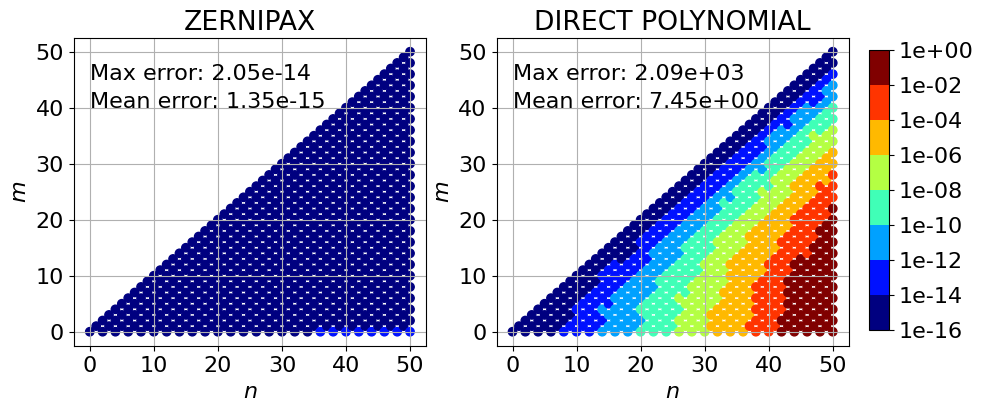

In [7]:
plot_comparison(
    zt0,
    (zr0, zp0),
    basis,
    dx=0,
    type="absolute",
    names=("ZERNIPAX", "DIRECT POLYNOMIAL"),
    print_error=True,
)
plt.savefig("acc0.png", dpi=1000, bbox_inches='tight')

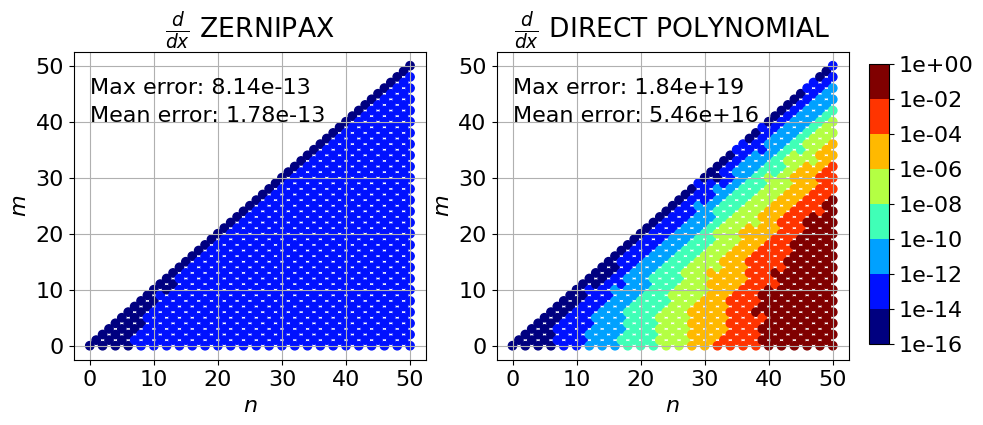

In [10]:
plot_comparison(
    zt1,
    (zr1, zp1),
    basis,
    dx=1,
    type="absolute",
    names=("$\\frac{d}{dx}$ ZERNIPAX", "$\\frac{d}{dx}$ DIRECT POLYNOMIAL"),
    print_error=True,
)
plt.savefig("acc1.png", dpi=1000, bbox_inches='tight')

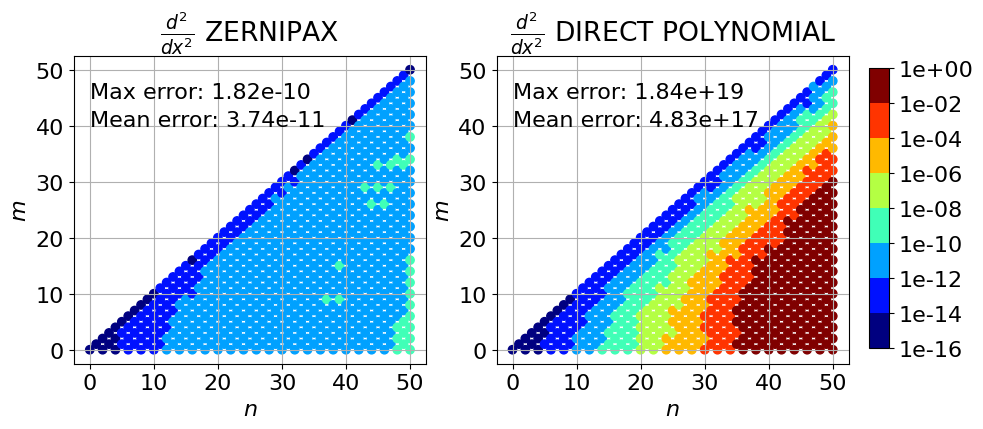

In [12]:
plot_comparison(
    zt2,
    (zr2, zp2),
    basis,
    dx=2,
    type="absolute",
    names=("$\\frac{d^2}{dx^2}$ ZERNIPAX", "$\\frac{d^2}{dx^2}$ DIRECT POLYNOMIAL"),
    print_error=True,
)
plt.savefig("acc2.png", dpi=1000, bbox_inches='tight')

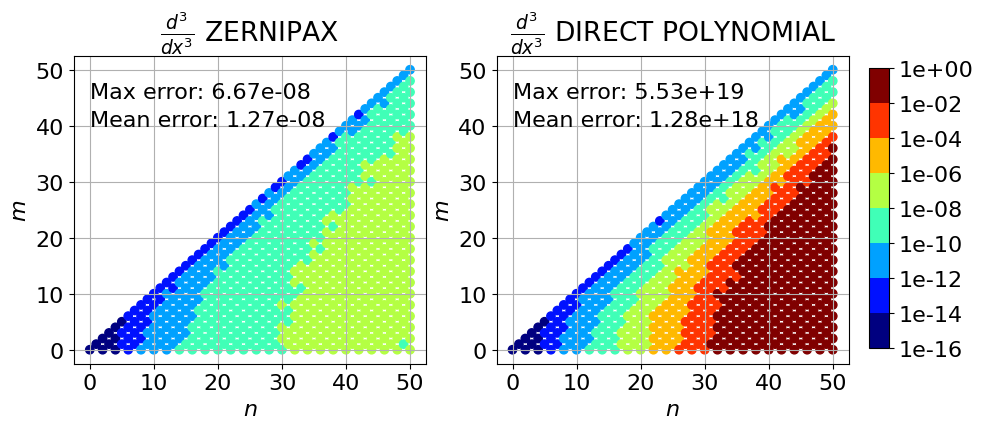

In [13]:
plot_comparison(
    zt3,
    (zr3, zp3),
    basis,
    dx=3,
    type="absolute",
    names=("$\\frac{d^3}{dx^3}$ ZERNIPAX", "$\\frac{d^3}{dx^3}$ DIRECT POLYNOMIAL"),
    print_error=True,
)
plt.savefig("acc3.png", dpi=1000, bbox_inches='tight')